# NLP and Classification

## Importing Libraries

In [1]:
import csv
import pandas as pd
# utilities
import re
import numpy as np
# plotting
import seaborn as sns
sns.set_style('white')
%matplotlib inline
from wordcloud import WordCloud
import matplotlib.pyplot as plt
# Data Preprocessing & NLP
import nltk
import string
import gensim
from textblob import Word

from gensim.utils import simple_preprocess
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import LabelBinarizer
#nltk.download('wordnet')
#nltk.download('punkt')

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier)
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import GridSearchCV
from sklearn.metrics.pairwise import linear_kernel

# Performance metrics
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics.pairwise import cosine_similarity

# Visualization Libraries
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [2]:
employees = pd.read_csv('employees.csv')

## Exploratory Data Analysis

In [3]:
employees.sample(5)

,id,person_name,nine_box_category,feedback,adjusted,reviewed
576,449,Daniel Carr,Category 6: 'High Performer' (High performance...,Daniel is a rock-solid member of the team and ...,False,True
156,127,Isabella James,Category 2: 'Average performer' (Moderate perf...,Isabella James is just here for the paycheck. ...,False,False
732,621,Dennis Buchanan,Category 8: 'High Potential' (Moderate perform...,Dennis is a consistently reliable as an employ...,False,False
338,277,Jay Reid,Category 4: 'Inconsistent Player' (Low perform...,Jay needs some work to fully unlock his capabi...,False,False
348,289,Alfie Wright,Category 4: 'Inconsistent Player' (Low perform...,Alfie's quantitative skills simply are not up ...,False,False


In [4]:
employees.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878 entries, 0 to 877
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 878 non-null    int64 
 1   person_name        878 non-null    object
 2   nine_box_category  878 non-null    object
 3   feedback           878 non-null    object
 4   adjusted           878 non-null    bool  
 5   reviewed           878 non-null    bool  
dtypes: bool(2), int64(1), object(3)
memory usage: 29.3+ KB


In [5]:
employees.describe()

,id
count,878.000000
mean,3235.269932
std,4956.401144
min,1.000000
25%,237.250000
50%,473.500000
75%,10019.750000
max,20222.000000


In [6]:
employees.sample(5)

,id,person_name,nine_box_category,feedback,adjusted,reviewed
443,207,Leo Lee,Category 5: 'Core Player' (Moderate performanc...,Leo is a solid worker. He's usually on time an...,True,True
11,15,George Gill,"Category 1: 'Risk' (Low performance, Low poten...",George was given ample warning last quarter th...,False,True
530,10104,Declan Houghton,Category 5: 'Core Player' (Moderate performanc...,Declan Houghton is a very consistent part of t...,False,False
611,10024,Cristian Fleming,Category 6: 'High Performer' (High performance...,Cristian is an integral part of the team and i...,False,True
252,199,Freya Price,Category 3: 'Solid Performer' (High performanc...,Freya Price has the right mindset and attitude...,False,False


In [7]:
employees.columns

Index(['id', 'person_name', 'nine_box_category', 'feedback', 'adjusted',
       'reviewed'],
      dtype='object')

In [8]:
print('length of data is', len(employees))

length of data is 878


In [9]:
employees.shape

(878, 6)

In [10]:
employees.dtypes

id                    int64
person_name          object
nine_box_category    object
feedback             object
adjusted               bool
reviewed               bool
dtype: object

In [11]:
np.sum(employees.isnull().any(axis=1))

0

In [12]:
employees.groupby('nine_box_category').describe()

id               \
                                                    count         mean   
nine_box_category                                                        
Category 1: 'Risk' (Low performance, Low potent...  126.0  4036.992063   
Category 2: 'Average performer' (Moderate perfo...  106.0  2874.547170   
Category 3: 'Solid Performer' (High performance...   89.0  2775.764045   
Category 4: 'Inconsistent Player' (Low performa...  113.0  2407.053097   
Category 5: 'Core Player' (Moderate performance...  112.0  2801.830357   
Category 6: 'High Performer' (High performance,...   91.0  3649.538462   
Category 7: 'Potential Gem' (Low performance, H...   41.0  4742.536585   
Category 8: 'High Potential' (Moderate performa...   88.0  2868.693182   
Category 9: 'Star' (High performance, High pote...  112.0  3708.589286   

                                                                        \
                                                            std    min   
nine_box_category                                                        
Category 1: 'Risk' (Low performance, Low potent...  6337.438549    1.0   
Category 2: 'Average performer' (Moderate perfo...  5237.138774   51.0   
Category 3: 'Solid Performer' (High performance...  4355.917182  177.0   
Category 4: 'Inconsistent Player' (Low performa...  4015.109358   73.0   
Category 5: 'Core Player' (Moderate performance...  4238.287976  106.0   
Category 6: 'High Performer' (High performance,...  5447.574688  217.0   
Category 7: 'Potential Gem' (Low performance, H...  4801.706546  534.0   
Category 8: 'High Potential' (Moderate performa...  4088.073732  495.0   
Category 9: 'Star' (High performance, High pote...  4995.451319  435.0   

                                                                             \
                                                       25%    50%       75%   
nine_box_category                                                             
Category 1: 'Risk' (Low performance, Low potent...   35.25   69.5  10046.75   
Category 2: 'Average performer' (Moderate perfo...  122.25  153.0    386.00   
Category 3: 'Solid Performer' (High performance...  201.00  235.0  10009.00   
Category 4: 'Inconsistent Player' (Low performa...  290.00  319.0    536.00   
Category 5: 'Core Player' (Moderate performance...  359.75  394.5   2975.00   
Category 6: 'High Performer' (High performance,...  440.50  467.0  10026.50   
Category 7: 'Potential Gem' (Low performance, H...  545.00  559.0  10073.00   
Category 8: 'High Potential' (Moderate performa...  583.75  608.5    633.25   
Category 9: 'Star' (High performance, High pote...  657.75  686.5  10042.25   

                                                             
                                                        max  
nine_box_category                                            
Category 1: 'Risk' (Low performance, Low potent...  20047.0  
Category 2: 'Average performer' (Moderate perfo...  20010.0  
Category 3: 'Solid Performer' (High performance...  10220.0  
Category 4: 'Inconsistent Player' (Low performa...  10221.0  
Category 5: 'Core Player' (Moderate performance...  10228.0  
Category 6: 'High Performer' (High performance,...  20222.0  
Category 7: 'Potential Gem' (Low performance, H...  10194.0  
Category 8: 'High Potential' (Moderate performa...  10227.0  
Category 9: 'Star' (High performance, High pote...  20024.0

In [13]:
employees['length'] = employees['feedback'].apply(len)
employees.sample(5)

,id,person_name,nine_box_category,feedback,adjusted,reviewed,length
350,291,Isaac Parry,Category 4: 'Inconsistent Player' (Low perform...,Isaac currently is not doing a good job. He is...,False,False,386
858,10120,Gunnar Herrera,"Category 9: 'Star' (High performance, High pot...",Gunnar is a high performing individual who con...,False,False,296
111,10207,Jaiden Horne,"Category 1: 'Risk' (Low performance, Low poten...",Jayden Horne is not a team player. She has sho...,False,False,194
604,481,Natasha Richardson,Category 6: 'High Performer' (High performance...,Natasha Richardson was a peak producer this qu...,False,True,358
574,447,Chelsea Ross,Category 6: 'High Performer' (High performance...,Chelsea Ross performed at a high level this pa...,False,False,287


## Data Visualization

In [14]:
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

In [15]:
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_words(employees['feedback'], 20)
for word, freq in common_words:
    print(word, freq)
df1 = pd.DataFrame(common_words, columns = ['feedback' , 'count'])
df1.groupby('feedback').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count',color="blue", linecolor='black', title='Top 20 words in feedback before cleaning')

to 2175
the 1548
and 1479
he 1415
is 1390
in 955
she 908
his 858
has 824
work 812
of 782
her 729
that 602
with 542
on 505
not 460
for 449
be 418
this 397
but 313


In [16]:
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_bigram(employees['feedback'], 20)
for word, freq in common_words:
    print(word, freq)
df4 = pd.DataFrame(common_words, columns = ['feedback' , 'count'])
df4.groupby('feedback').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 bigrams in "feedback" column')

quality work 57
work product 37
member team 37
work ethic 31
team player 30
work time 28
high potential 23
day day 20
high quality 19
work does 19
communication skills 18
team member 17
room grow 17
moving forward 16
future company 15
does work 15
good work 15
timely manner 14
moderate potential 14
time work 13


In [17]:
employees['length'].iplot(
    kind='hist',
    bins=50,
    xTitle='Length',
    linecolor='black',
    yTitle='count',
    title='Feedback Length Distribution')

<AxesSubplot:ylabel='Frequency'>

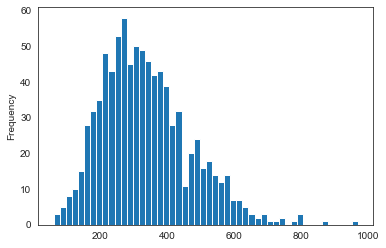

In [18]:
employees['length'].plot(bins=50, kind='hist') 

In [19]:
employees.length.describe()

count    878.000000
mean     335.930524
std      133.783240
min       61.000000
25%      238.250000
50%      317.000000
75%      408.750000
max      971.000000
Name: length, dtype: float64

In [20]:
employees[employees['length'] == 971]['feedback'].iloc[0]

"Ms. Amaya, I appreciate you taking the time to look over my feedback. During your time at this company, your work has been consistent. You have not done anything that is strikingly bad. However, you have yet to 'wow' any of the superiors with your work. Unfortunately this has led some to believe that your potential at this company is limited. If you hope to stay at this company and advance, I might advise you to try and put in a little extra effort. The bare minimum is a typically accepted standard, especially if the work is accurate and meets requirements. However, the bare minimum does not encourage others to see you as a 'good' worker or recognize you for your performance. While your work here has been satisfactory thus far and I have no complaints, I implore you to attempt to catch the interest of your superiors. This will benefit you in the long run at this company and hopefully invigorate your desire to be here. A little extra effort can go along way!"

### Feedback Sentiment Function

In [21]:
employees["feedback_sentiment"] = employees["nine_box_category"].apply(lambda x: "Positive Feedback" if x == "Category 9: 'Star' (High performance, High potential)" 
                                                                  or x=="Category 8: 'High Potential' (Moderate performance, High potential)" 
                                                                  or x=="Category 6: 'High Performer' (High performance, Moderate potential)"
                                                                  or x=="Category 3: 'Solid Performer' (High performance, Low potential)"
                                                                  or x=="Category 5: 'Core Player' (Moderate performance, Moderate potential)"
                                                                  else "Negative Feedback" )

In [22]:
employees.sample(10)

,id,person_name,nine_box_category,feedback,adjusted,reviewed,length,feedback_sentiment
135,96,Bailey Hunter,Category 2: 'Average performer' (Moderate perf...,"Bailey has always been an average worker, noti...",False,False,118,Negative Feedback
812,677,Chelsea Stevens,"Category 9: 'Star' (High performance, High pot...",Chelsea Stevens is an ideal employee. She deli...,False,False,204,Positive Feedback
274,231,Braydon Terrell,Category 3: 'Solid Performer' (High performanc...,Braydon Terrell has been a solid performer for...,False,False,399,Positive Feedback
810,675,Gavyn Acevedo,"Category 9: 'Star' (High performance, High pot...",Gavyn an absolutely employee. His work is alwa...,False,False,382,Positive Feedback
435,107,Joel Wells,Category 5: 'Core Player' (Moderate performanc...,Joel is an able worker who is yet to really de...,True,True,366,Positive Feedback
179,154,Amy John,Category 2: 'Average performer' (Moderate perf...,Amy John is dedicated to the work atmosphere a...,False,False,495,Negative Feedback
182,159,Joel Wells,Category 2: 'Average performer' (Moderate perf...,"When Joel is engaged in his work,he can be ve...",False,False,196,Negative Feedback
836,701,Emilie Carroll,"Category 9: 'Star' (High performance, High pot...",Emilie has quickly made her self an important ...,False,False,455,Positive Feedback
579,453,Madison Hawkins,Category 6: 'High Performer' (High performance...,Madison Hawkins continuously goes above and be...,False,False,386,Positive Feedback
624,10149,Bethany Cunningham,Category 6: 'High Performer' (High performance...,Bethany shows great character and is very effi...,False,False,475,Positive Feedback


<AxesSubplot:xlabel='feedback_sentiment', ylabel='nine_box_category'>

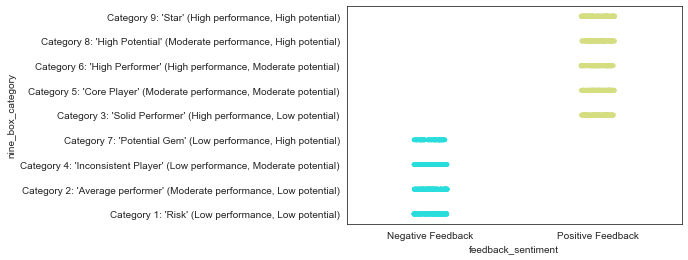

In [23]:
sns.stripplot(x='feedback_sentiment',y='nine_box_category',data=employees,palette='rainbow')

In [24]:
employees['feedback_sentiment'].iplot(
    kind='hist',
    xTitle='Rating',
    color="blue",
    linecolor='black',
    yTitle='Count',
    title='Feedback Rating Distribution')

**Create a countplot of the number of occurrences for each type of feedback rating.**

<AxesSubplot:xlabel='feedback_sentiment', ylabel='count'>

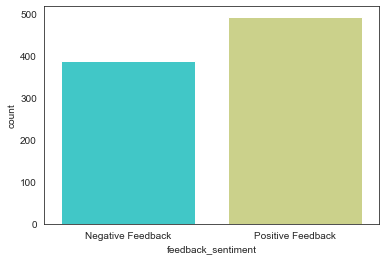

In [25]:
sns.countplot(x='feedback_sentiment',data=employees,palette='rainbow')

array([<AxesSubplot:title={'center':'Negative Feedback'}>,
       <AxesSubplot:title={'center':'Positive Feedback'}>], dtype=object)

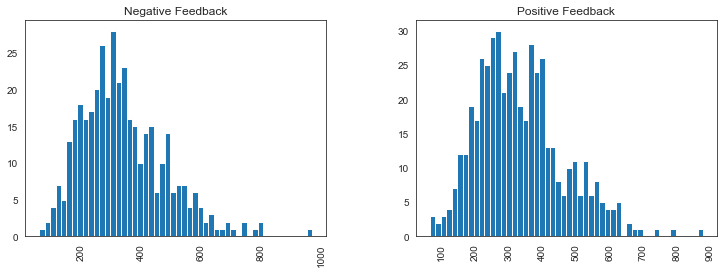

In [26]:
employees.hist(column='length', by='feedback_sentiment', bins=50,figsize=(12,4))

## Text Pre-processing

In [27]:
employees.sample(5)

,id,person_name,nine_box_category,feedback,adjusted,reviewed,length,feedback_sentiment
348,289,Alfie Wright,Category 4: 'Inconsistent Player' (Low perform...,Alfie's quantitative skills simply are not up ...,False,False,495,Negative Feedback
776,639,Theodor Peters,"Category 9: 'Star' (High performance, High pot...",Theodor has consistently been a very promising...,False,False,396,Positive Feedback
208,10008,Harvey Watts,Category 2: 'Average performer' (Moderate perf...,Harvey Watts is a very regular worker. His com...,False,False,234,Negative Feedback
792,656,Emilie Carroll,"Category 9: 'Star' (High performance, High pot...",Emilie is such an absolute pleasure to work wi...,False,False,520,Positive Feedback
1,2,John Carter,"Category 1: 'Risk' (Low performance, Low poten...",John has consistently disappointed me this qua...,False,True,485,Negative Feedback


In [28]:
#dropping irrelevant columns
columns_to_delete = ['id','person_name', 'adjusted','reviewed','length'] #'nine_box_category',
employees.drop(columns_to_delete, inplace=True, axis=1)

In [29]:
employees.drop("nine_box_category", inplace=True, axis=1)

In [30]:
employees.sample(5)

,feedback,feedback_sentiment
715,Deegan is a great employee that delivers what ...,Positive Feedback
97,"Layla Scott, a Customer Service Representative...",Negative Feedback
155,she tries hard but she is in the wrong positio...,Negative Feedback
812,Chelsea Stevens is an ideal employee. She deli...,Positive Feedback
281,Edward is doing such a great job with his work...,Positive Feedback


Let's create a function that will process the string in the feedback column, then we can just use **apply()** in pandas do process all the text in the DataFrame.

In [31]:
# return the wordnet object value corresponding to the POS tag
from nltk.corpus import wordnet

def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
import string
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer

def clean_text(text):
    # lower text
    text = text.lower()
    # tokenize text and remove puncutation
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    # remove words that contain numbers
    text = [word for word in text if not any(c.isdigit() for c in word)]
    # remove stop words
    stop = stopwords.words('english')
    text = [x for x in text if x not in stop]
    # remove empty tokens
    text = [t for t in text if len(t) > 0]
    # pos tag text
    pos_tags = pos_tag(text)
    # lemmatize text
    text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    # remove words with only one letter
    text = [t for t in text if len(t) > 1]
    # join all
    text = " ".join(text)
    return(text)

# clean text data
employees["feedback_clean"] = employees["feedback"].apply(lambda x: clean_text(x))



To clean textual data, i made a 'clean_text' function that performs several transformations:
- lower the text
- tokenize the text (split the text into words) and remove the punctuation
- remove useless words that contain numbers
- remove useless stop words like 'the', 'a' ,'this' etc.
- Part-Of-Speech (POS) tagging: assign a tag to every word to define if it corresponds to a noun, a verb etc. using the WordNet lexical database
- lemmatize the text: transform every word into their root form (e.g. jobs -> job, felt -> feel)


In [32]:
#pd.set_option('display.max_colwidth', None)

In [33]:
employees.sample(2)

,feedback,feedback_sentiment,feedback_clean
740,Chanel has shown great improvement this year. ...,Positive Feedback,chanel show great improvement year willingness...
145,Sara was a great colleague of mine. she did he...,Negative Feedback,sara great colleague mine day day task meet ex...


In [34]:
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_words(employees['feedback_clean'], 20)
for word, freq in common_words:
    print(word, freq)
df1 = pd.DataFrame(common_words, columns = ['feedback_clean' , 'count'])
df1.groupby('feedback_clean').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count',color="blue", linecolor='black', title='Top 20 words in feedback after cleaning')

work 942
time 350
team 310
show 297
improve 239
company 235
well 226
potential 224
performance 204
task 204
good 194
need 192
great 186
always 181
worker 164
see 154
take 150
however 149
job 147
high 142


### Feature Engineering

In [35]:
# add sentiment anaylsis columns
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()
employees["sentiments"] = employees["feedback"].apply(lambda x: sid.polarity_scores(x))
employees = pd.concat([employees.drop(['sentiments'], axis=1), employees['sentiments'].apply(pd.Series)], axis=1)

In [36]:
employees.sample(5)

,feedback,feedback_sentiment,feedback_clean,neg,neu,pos,compound
652,Basically Briley Mcknight have high potential...,Negative Feedback,basically briley mcknight high potential work ...,0.061,0.939,0.000,-0.3919
642,Brantley continues to be less productive than ...,Negative Feedback,brantley continue less productive believe coul...,0.000,0.758,0.242,0.9423
673,Erin has proven that she has a love for what s...,Negative Feedback,erin proven love push performance low work tur...,0.038,0.845,0.117,0.5403
500,Alex's work is greatly appreciated. He achieve...,Positive Feedback,alex's work greatly appreciated achieves level...,0.032,0.738,0.230,0.9442
768,Chelsea has earned a high performer rating. D...,Positive Feedback,chelsea earn high performer rating evaluation ...,0.000,0.887,0.113,0.7574


### Text Mining Algorithms

In [37]:
# Lemmatization process
'''
Words in the third person are changed to first person and verbs in past and future tenses are changed into the present by the 
lemmatization process. 
'''
lemmatizer = WordNetLemmatizer()

def tokenize_and_lemmatize(text):
    # tokenization to ensure that punctuation is caught as its own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    lem = [lemmatizer.lemmatize(t) for t in filtered_tokens]
    return lem

### Vectorization

In [38]:
# add number of characters column
#employees["nb_chars"] = employees["feedback"].apply(lambda x: len(x))

# add number of words column
#employees["nb_words"] = employees["feedback"].apply(lambda x: len(x.split(" ")))

In [39]:
employees.sample(5)

,feedback,feedback_sentiment,feedback_clean,neg,neu,pos,compound
734,Dennis joined the company last year. Since the...,Positive Feedback,dennis join company last year since dennis pro...,0.086,0.738,0.176,0.5574
49,Caiden Pace has repeatedly showed a lack of mo...,Negative Feedback,caiden pace repeatedly show lack motivation dr...,0.120,0.782,0.098,-0.1729
265,Nolan performs well when given direction Nolan...,Positive Feedback,nolan performs well give direction nolan's per...,0.000,0.848,0.152,0.7996
260,Emilia has produced amazing quality of work th...,Positive Feedback,emilia produce amazing quality work quarter wo...,0.032,0.795,0.173,0.8653
485,kyle lawson is a core player of our department...,Positive Feedback,kyle lawson core player department despite mod...,0.000,1.000,0.000,0.0000


In [40]:
# Defining a Count Vectorizer object
count_vec = CountVectorizer(stop_words='english', max_features=10000)
# Defining a TF-IDF Vectorizer
tfidf_vec = TfidfVectorizer(stop_words='english', ngram_range=(1, 2), tokenizer=tokenize_and_lemmatize, max_features=10000, use_idf=True) #clean_text,tokenize_and_lemmatize

In [41]:
#mb = MultiLabelBinarizer() #mb = MultiLabelBinarizer()
#y=mb.fit_transform(employees['feedback_sentiment'].dropna().str.split(', '))
#print (y)
#print(mb.classes_ )
#print(y.shape)

In [42]:
y=employees['feedback_sentiment']

In [43]:
X_train, X_test, y_train, y_test = train_test_split(employees['feedback_clean'], y, test_size=0.2, random_state=55)

### TF-IDF

In [44]:
import warnings
warnings.filterwarnings('ignore')

In [45]:
# Tf-Idf transformation 
xtrain_tfidf = tfidf_vec.fit_transform(X_train)
xtest_tfidf = tfidf_vec.transform(X_test)
xtrain_tfidf.shape

(702, 10000)

In [46]:
# Count Vectorizer transformation
xtrain_cv = count_vec.fit_transform(X_train)
xtest_cv = count_vec.transform(X_test)
xtrain_cv.shape

(702, 2614)

## Exploratory data analysis (2)

In [47]:
# show is_good_feedback distribution
employees["feedback_sentiment"].value_counts(normalize = True)

Positive Feedback    0.560364
Negative Feedback    0.439636
Name: feedback_sentiment, dtype: float64

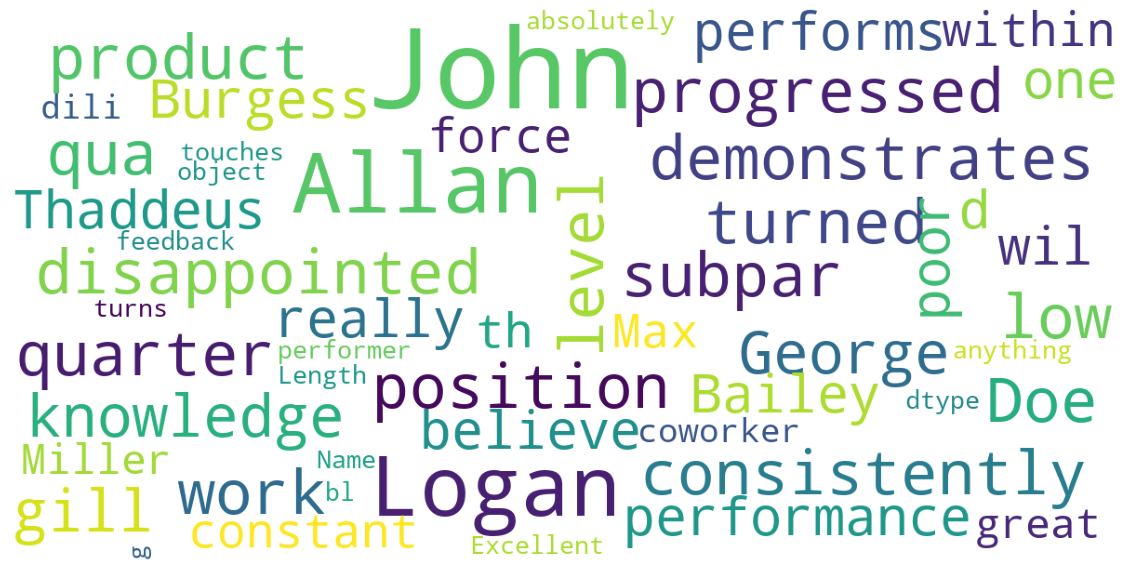

In [48]:
# wordcloud function

from wordcloud import WordCloud
import matplotlib.pyplot as plt

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color = 'white',
        max_words = 200,
        max_font_size = 40, 
        scale = 3,
        random_state = 42
    ).generate(str(data))

    fig = plt.figure(1, figsize = (20, 20))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 2.3)

    plt.imshow(wordcloud)
    plt.show()
    
# print wordcloud
show_wordcloud(employees["feedback"])

In [49]:
# add number of characters column
employees["nb_chars"] = employees["feedback"].apply(lambda x: len(x))

# add number of words column
employees["nb_words"] = employees["feedback"].apply(lambda x: len(x.split(" ")))

In [51]:
# highest positive sentiment reviews (with more than 5 words)
employees[employees["nb_words"] >= 5].sort_values("pos", ascending = False)[["feedback", "pos"]].head(10)

,feedback,pos
453,Generally of good speed.\nSightly enthusiast.\...,0.596
215,"Joyce douglas is a pleasure to have at work, s...",0.553
170,He is a good player.\nshould improve on speed....,0.512
286,Willingness to accomplish. Needs constant coac...,0.502
41,wade shows no meaningful improvements and will...,0.482
421,Lexi Rogers Is one of best workers. He is good...,0.475
190,Requires additional encouragement. Needs mento...,0.450
402,Alina Britt offer potential solutions to a pro...,0.417
819,Hey Nathan! You've been doing a great job late...,0.409
217,Teagan Pate Is getting better at performance. ...,0.407


In [52]:
# lowest negative sentiment reviews (with more than 5 words)
employees[employees["nb_words"] >= 5].sort_values("neg", ascending = False)[["feedback", "neg"]].head(10)

,feedback,neg
88,You have poor potential to make value judgment...,0.277
54,Mr Geroge Gill struggles to get the task done....,0.231
483,Finley is an average worker with nothing extra...,0.218
106,Katherine has a bad attitude towards work and ...,0.213
402,Alina Britt offer potential solutions to a pro...,0.211
13,Libby started off well but no longer has motiv...,0.204
29,Kayden Hill struggles with the tasks set befor...,0.200
655,He has the ability to extract an idea about pa...,0.197
356,Lacey was very tough to deal with. She never s...,0.193
89,Freddie has been quite disappointing this quar...,0.190


## Classification

With feedbacks represented as vectors, we can finally train our model. Now we can actually use almost any sort of classification algorithms

### Model Evaluation Function

In [53]:
from sklearn.metrics import confusion_matrix, classification_report
def model_Evaluate(model):
    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)
    categories = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
    labels = [f'{v1}:{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
    xticklabels = categories, yticklabels = categories)
    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

# Model building

## KNN

In [60]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier()
neigh.fit(xtrain_tfidf, y_train)
y_pred = neigh.predict(xtest_tfidf)
# Performance metrics
accuracy, precision, recall, f1score = get_performance(y_test, y_pred)
print(f'Test Accuracy Score of KNN.: {accuracy} % ')
print(f'Precision :{round((precision) * 100,2)} % ')
print(f'Recall    :{round((recall) * 100,2)} % ')
print(f'F1-score   :{round((f1score) * 100,2)} % ')

Test Accuracy Score of KNN.: 76.7 % 
Precision :78.0 % 
Recall    :75.86 % 
F1-score   :75.96 % 


In [61]:
neigh.get_params().keys()

dict_keys(['algorithm', 'leaf_size', 'metric', 'metric_params', 'n_jobs', 'n_neighbors', 'p', 'weights'])

In [62]:
param = {'n_neighbors':range(20), 'weights':['uniform,','distance'],'metric':['euclidean','manhattan']}

In [63]:
# GridSearchCV
kf=KFold(n_splits=10, shuffle=True, random_state=55)
KNN_grid = GridSearchCV(neigh, param_grid = param, cv = kf, n_jobs=-1)
KNN_grid.fit(xtrain_tfidf, y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=55, shuffle=True),
             estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': range(0, 20),
                         'weights': ['uniform,', 'distance']})

In [64]:
# examine the best model
print(KNN_grid.best_score_)
print(KNN_grid.best_params_)
print(KNN_grid.best_estimator_)

0.8119315895372233
{'metric': 'euclidean', 'n_neighbors': 6, 'weights': 'distance'}
KNeighborsClassifier(metric='euclidean', n_neighbors=6, weights='distance')


In [65]:
neigh_grid = KNeighborsClassifier(metric='euclidean', weights='distance',n_neighbors=6)
neigh_grid.fit(xtrain_tfidf, y_train)
y_pred = neigh_grid.predict(xtest_tfidf)
# Performance metrics
accuracy, precision, recall, f1score = get_performance(y_test, y_pred)
print(f'Test Accuracy Score of KNN.: % {accuracy}')
print(f'Precision :% {round((precision) * 100,2)}')
print(f'Recall    :% {round((recall) * 100,2)}')
print(f'F1-score   :% {round((f1score) * 100,2)}')

Test Accuracy Score of KNN.: % 81.25
Precision :% 82.27
Recall    :% 80.58
F1-score   :% 80.8


In [66]:
# Add performance parameters to list
evaluation_list.append(dict([
    ('Model', 'KNN'),
    ('Test Accuracy', round(accuracy, 2)),
    ('Precision', round((precision),2)),
    ('Recall', round(recall, 2)),
    ('F1', round(f1score, 2))
     ]))

In [67]:
y_pred[16] #mb.inverse_transform(y_pred)[16]

'Negative Feedback'

### Logistic Regression

In [54]:
log_reg = LogisticRegression(C=10, penalty='l2')
log_reg.fit(xtrain_tfidf, y_train)

LogisticRegression(C=10)

In [55]:
y_pred = log_reg.predict(xtest_tfidf)

def get_performance(y_test, y_pred):
    # Evaluate Performance
    accuracy = round(accuracy_score(y_test, y_pred) * 100, 2)
    # Get precision, recall, f1 scores
    precision, recall, f1score, support = score(y_test, y_pred, average='macro')
    return accuracy, precision, recall, f1score

# Performance metrics
accuracy, precision, recall, f1score = get_performance(y_test, y_pred)
print(f'Test Accuracy Score of Logistic Reg.: % {accuracy}')
print(f'Precision :% {round((precision) * 100,2)}')
print(f'Recall    :% {round((recall) * 100,2)}')
print(f'F1-score   :% {round((f1score) * 100,2)}')

Test Accuracy Score of Logistic Reg.: % 82.95
Precision :% 83.67
Recall    :% 82.41
F1-score   :% 82.63


In [71]:

from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold, cross_val_score


#clf = log_reg = LogisticRegression()

#k_folds = KFold(n_splits = 10)

#scores = cross_val_score(clf,xtrain_tfidf,y_train, cv = k_folds)

#print("Cross Validation Scores: ", scores)
#print("Average CV Score: ", scores.mean())
#print("Number of CV Scores used in Average: ", len(scores)) 

Cross Validation Scores:  [0.83098592 0.77464789 0.68571429 0.81428571 0.65714286 0.74285714
 0.7        0.72857143 0.67142857 0.82857143]
Average CV Score:  0.7434205231388329
Number of CV Scores used in Average:  10


In [56]:
# to hold model's results
evaluation_list=[]

In [57]:
# Add performance parameters to list
evaluation_list.append(dict([
    ('Model', 'Logistic Regression'),
    ('Test Accuracy', round(accuracy, 2)),
    ('Precision', round((precision),2)),
    ('Recall', round(recall, 2)),
    ('F1', round(f1score, 2))
     ]))

In [58]:
y_pred[16] #mb.inverse_transform(y_pred)[16]

'Negative Feedback'

                   precision    recall  f1-score   support

Negative Feedback       0.87      0.74      0.80        82
Positive Feedback       0.80      0.90      0.85        94

         accuracy                           0.83       176
        macro avg       0.84      0.82      0.83       176
     weighted avg       0.83      0.83      0.83       176



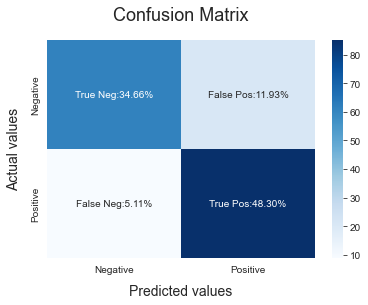

In [59]:
model_Evaluate(log_reg)

### Multinomial Naive Bayes

In [68]:
nbayes = MultinomialNB()
nbayes.fit(xtrain_tfidf, y_train)

MultinomialNB()

In [69]:
y_pred = nbayes.predict(xtest_tfidf)

# Performance metrics
accuracy, precision, recall, f1score = get_performance(y_test, y_pred)
print(f'Test Accuracy Score of Basic Multinomial Naive Bayes.: % {accuracy}')
print(f'Precision :% {round((precision) * 100,2)}')
print(f'Recall    :% {round((recall) * 100,2)}')
print(f'F1-score   :% {round((f1score) * 100,2)}')

Test Accuracy Score of Basic Multinomial Naive Bayes.: % 72.16
Precision :% 80.39
Recall    :% 70.28
F1-score   :% 68.9


In [70]:
nbayes.get_params().keys()

dict_keys(['alpha', 'class_prior', 'fit_prior'])

In [71]:
paramn = {'alpha':range(20)}

In [84]:
# GridSearchCV
kf=KFold(n_splits=10, shuffle=True, random_state=55)
nb_grid = GridSearchCV(nbayes, param_grid = paramn, cv = kf, n_jobs=-1)
nb_grid.fit(xtrain_tfidf, y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=55, shuffle=True),
             estimator=MultinomialNB(), n_jobs=-1,
             param_grid={'alpha': range(0, 20)})

In [85]:
# examine the best model
print(nb_grid.best_score_)
print(nb_grid.best_params_)
print(nb_grid.best_estimator_)

0.7977263581488934
{'alpha': 0}
MultinomialNB(alpha=0)


In [72]:
nb_grid = MultinomialNB(alpha=0)
nb_grid.fit(xtrain_tfidf, y_train)
y_pred = nb_grid.predict(xtest_tfidf)
# Performance metrics
accuracy, precision, recall, f1score = get_performance(y_test, y_pred)
print(f'Test Accuracy Score of MultinomialNB.: % {accuracy}')
print(f'Precision :% {round((precision) * 100,2)}')
print(f'Recall    :% {round((recall) * 100,2)}')
print(f'F1-score   :% {round((f1score) * 100,2)}')

Test Accuracy Score of MultinomialNB.: % 81.25
Precision :% 81.78
Recall    :% 80.73
F1-score   :% 80.92


In [73]:
# Add performance parameters to list
evaluation_list.append(dict([
    ('Model', 'MultinomialNB'),
    ('Test Accuracy', round(accuracy, 2)),
    ('Precision', round(precision, 2)),
    ('Recall', round(recall, 2)),
    ('F1', round(f1score, 2))
     ]))

                   precision    recall  f1-score   support

Negative Feedback       0.85      0.73      0.78        82
Positive Feedback       0.79      0.88      0.83        94

         accuracy                           0.81       176
        macro avg       0.82      0.81      0.81       176
     weighted avg       0.82      0.81      0.81       176



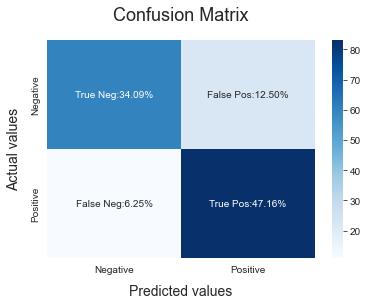

In [74]:
model_Evaluate(nb_grid)

In [75]:
(y_pred)[16]

'Negative Feedback'

### Linear SVC

In [76]:
linear_svc = LinearSVC()
linear_svc.fit(xtrain_tfidf, y_train)

LinearSVC()

In [77]:
y_pred = linear_svc.predict(xtest_tfidf)

# Performance metrics
accuracy, precision, recall, f1score = get_performance(y_test, y_pred)
print(f'Test Accuracy Score of Basic Linear SVC.: % {accuracy}')
print(f'Precision :% {round((precision) * 100,2)}')
print(f'Recall    :% {round((recall) * 100,2)}')
print(f'F1-score   :% {round((f1score) * 100,2)}')

Test Accuracy Score of Basic Linear SVC.: % 84.09
Precision :% 84.62
Recall    :% 83.63
F1-score   :% 83.84


In [92]:
paramsvc = {'penalty':['l1', 'l2'], 'C':[0.001, 0.01, 1, 10]}

In [91]:
linear_svc.get_params().keys()

dict_keys(['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'loss', 'max_iter', 'multi_class', 'penalty', 'random_state', 'tol', 'verbose'])

In [93]:
# GridSearchCV
kf=KFold(n_splits=10, shuffle=True, random_state=55)
SVC_grid = GridSearchCV(linear_svc, param_grid = paramsvc, cv = kf, scoring='f1_micro', n_jobs=-1)
SVC_grid.fit(xtrain_tfidf, y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=55, shuffle=True),
             estimator=LinearSVC(), n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 1, 10], 'penalty': ['l1', 'l2']},
             scoring='f1_micro')

In [94]:
# examine the best model
print(SVC_grid.best_score_)
print(SVC_grid.best_params_)
print(SVC_grid.best_estimator_)

0.8461569416498993
{'C': 10, 'penalty': 'l2'}
LinearSVC(C=10)


In [78]:
# Optimized Linear SVC Model
Grid_linear_svc = LinearSVC(C=10, penalty='l2')
Grid_linear_svc.fit(xtrain_tfidf, y_train)

LinearSVC(C=10)

In [79]:
# performance metrics of the optimized model
y_pred = Grid_linear_svc.predict(xtest_tfidf)

accuracy, precision, recall, f1score = get_performance(y_test, y_pred)
print(f'Test Accuracy Score of Grid SVC.: % {accuracy}')
print(f'Precision : {precision}')
print(f'Recall    : {recall}')
print(f'F1-score   : {f1score}')

Test Accuracy Score of Grid SVC.: % 86.36
Precision : 0.8657894736842104
Recall    : 0.8606642449403217
F1-score   : 0.8621949628082995


In [80]:
# Add performance parameters to list
evaluation_list.append(dict([
    ('Model', 'Linear SVC'),
    ('Test Accuracy', round(accuracy, 2)),
    ('Precision', round(precision, 2)),
    ('Recall', round(recall, 2)),
    ('F1', round(f1score, 2))
     ]))

                   precision    recall  f1-score   support

Negative Feedback       0.88      0.82      0.85        82
Positive Feedback       0.85      0.90      0.88        94

         accuracy                           0.86       176
        macro avg       0.87      0.86      0.86       176
     weighted avg       0.86      0.86      0.86       176



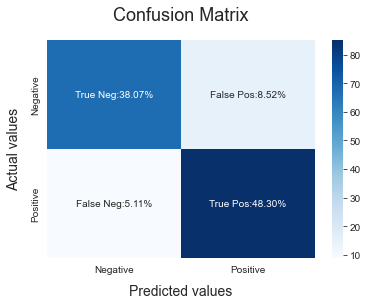

In [82]:
model_Evaluate(Grid_linear_svc)

In [83]:
(y_pred)[16]

'Negative Feedback'

### Random Forest

In [84]:
rforest = RandomForestClassifier(n_estimators=100)
rforest.fit(xtrain_tfidf, y_train)

RandomForestClassifier()

In [85]:
y_pred = rforest.predict(xtest_tfidf)

# Performance metrics
accuracy, precision, recall, f1score = get_performance(y_test, y_pred)
print(f'Test Accuracy Score of Basic Random Forest.: % {accuracy}')
print(f'Precision :% {round((precision) * 100,2)}')
print(f'Recall    :% {round((recall) * 100,2)}')
print(f'F1-score   :% {round((f1score) * 100,2)}')

Test Accuracy Score of Basic Random Forest.: % 74.43
Precision :% 76.52
Recall    :% 73.34
F1-score   :% 73.25


In [102]:
rforest.get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [111]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

In [112]:
paramrf = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [113]:
print(paramrf)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [114]:
from sklearn.model_selection import RandomizedSearchCV
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rforest, param_distributions = paramrf, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)# Fit the random search model
rf_random.fit(xtrain_tfidf, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [115]:
rf_random.best_params_

{'n_estimators': 1000,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 50,
 'bootstrap': False}

In [86]:
rforest_cv = RandomForestClassifier(n_estimators=1000,min_samples_split=2,min_samples_leaf=1,max_features='auto',max_depth=50,bootstrap=False)
rforest_cv.fit(xtrain_tfidf, y_train)
y_pred = rforest_cv.predict(xtest_tfidf)

# Performance metrics
accuracy, precision, recall, f1score = get_performance(y_test, y_pred)
print(f'Test Accuracy Score of Random Forest.: % {accuracy}')
print(f'Precision :% {round((precision) * 100,2)}')
print(f'Recall    :% {round((recall) * 100,2)}')
print(f'F1-score   :% {round((f1score) * 100,2)}')

Test Accuracy Score of Random Forest.: % 73.86
Precision :% 74.04
Recall    :% 73.35
F1-score   :% 73.45


In [87]:
# Add performance parameters to list
evaluation_list.append(dict([
    ('Model', 'Random Forest'),
    ('Test Accuracy', round(accuracy, 2)),
    ('Precision', round(precision, 2)),
    ('Recall', round(recall, 2)),
    ('F1', round(f1score, 2))
     ]))

                   precision    recall  f1-score   support

Negative Feedback       0.75      0.66      0.70        82
Positive Feedback       0.73      0.81      0.77        94

         accuracy                           0.74       176
        macro avg       0.74      0.73      0.73       176
     weighted avg       0.74      0.74      0.74       176



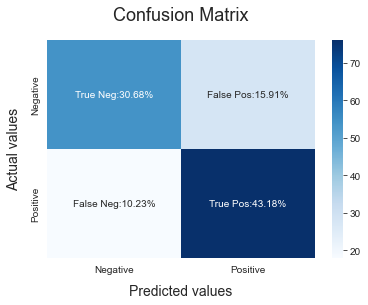

In [88]:
model_Evaluate(rforest_cv)

### BernoulliNB

In [89]:
from sklearn.naive_bayes import BernoulliNB
BNBmodel = BernoulliNB()
BNBmodel.fit(xtrain_tfidf, y_train)

BernoulliNB()

In [90]:
y_pred = BNBmodel.predict(xtest_tfidf)

# Performance metrics
accuracy, precision, recall, f1score = get_performance(y_test, y_pred)
print(f'Test Accuracy Score of Basic BNB.: % {accuracy}')
print(f'Precision :% {round((precision) * 100,2)}')
print(f'Recall    :% {round((recall) * 100,2)}')
print(f'F1-score   :% {round((f1score) * 100,2)}')

Test Accuracy Score of Basic BNB.: % 68.75
Precision :% 79.91
Recall    :% 66.54
F1-score   :% 63.81


In [91]:
# Add performance parameters to list
evaluation_list.append(dict([
    ('Model', 'BernoulliNB'),
    ('Test Accuracy', round(accuracy, 2)),
    ('Precision', round(precision, 2)),
    ('Recall', round(recall, 2)),
    ('F1', round(f1score, 2))
     ]))

                   precision    recall  f1-score   support

Negative Feedback       0.97      0.34      0.50        82
Positive Feedback       0.63      0.99      0.77        94

         accuracy                           0.69       176
        macro avg       0.80      0.67      0.64       176
     weighted avg       0.79      0.69      0.65       176



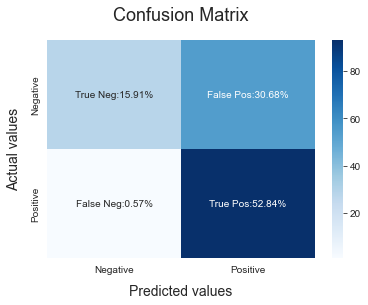

In [92]:
model_Evaluate(BNBmodel)

### Performance metrics of models

In [93]:
results = pd.DataFrame(data=evaluation_list)
results = results[['Model', 'Test Accuracy', 'Precision', 'Recall', 'F1']]
results = results.sort_values(by='F1', ascending=False)
results = results.set_index('Model')
results

,Test Accuracy,Precision,Recall,F1
Model,,,,
Linear SVC,86.36,0.87,0.86,0.86
Logistic Regression,82.95,0.84,0.82,0.83
KNN,81.25,0.82,0.81,0.81
MultinomialNB,81.25,0.82,0.81,0.81
Random Forest,73.86,0.74,0.73,0.73
BernoulliNB,68.75,0.80,0.67,0.64


## Prediction

In [214]:
# Inference funct to handle new data that will come in the future
def infer_sentiment(text):
    text = clean_text(text)
    text_vec = tfidf_vec.transform([text])
    y_pred = ovr.predict(text_vec)
    return mb.inverse_transform(y_pred)

In [215]:
for i in range(10):
    sp = X_test.sample(1).index[0]
    print("Feedback: " ,employees['feedback'][sp], "\nPredicted Sentiment: ", infer_tags(X_test[sp])), print("Actual Sentiment: ",employees['feedback_sentiment'][sp], "\n")   

Feedback:  Broderick Hays has been a member of our team for the past year.  He has demonstrated a lack of motivation during work hours.  There have been several customer complaints due to unresolved issues.  Unfortunately, we are unable to continue his employment at this time. 
Predicted Sentiment:  [('Bad Feedback',)]
Actual Sentiment:  Bad Feedback 

Feedback:  Mr. Cain started with the company last month and every day has been a ray of sunshine, until it's time to get to work.. Mr. Cain gives 110 percent to every task he likes and is always there to help people, when he feels  like it. If a customers is not to his liking or if it is a Thursday, Mr. Cain is rude in manner and has to be removed from the floor. We wish we could see more consistent performance from Mr. Cain, as right now we are frustrated with his inconsistent performance. 
Predicted Sentiment:  [('Bad Feedback',)]
Actual Sentiment:  Bad Feedback 

Feedback:  Tom Barrett needs to work harder. I often see him playing on 

In [216]:
infer_sentiment("Fedi is always absent , he has potential but sadly he dosn't show it, he always comes late and rarely finishes his work on time")

[('Bad Feedback',)]

In [218]:
#works hard

In [217]:
infer_sentiment('Fedi has improved a lot and is working hard , if he keeps working like this he will definitly become the star of the company ')

[('Good Feedback',)]

## Saving The Model For deployment

In [225]:
import pickle
import joblib

In [226]:
filename = "NLP_model.joblib"

In [227]:
#joblib.dump(ovr, filename)

['NLP_model.joblib']

In [ ]:
#joblib.dump(tfidf_obj, NLP_TFIDF.joblib)